# Dynamic Models of Buildings and HVAC Controllers

Based on the approach proposed by Patel et al. (2016):

- N. R. Patel, M. J. Risbeck, J. B. Rawlings, M. J. Wenzel and R. D. Turney, "Distributed economic model predictive control for large-scale building temperature regulation," 2016 American Control Conference (ACC), Boston, MA, USA, 2016, pp. 895-900, doi: 10.1109/ACC.2016.7525028. https://ieeexplore.ieee.org/document/7525028

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import casadi as cas

## Building Temperature Models

Single zone model

$$C \frac{dT}{dt} = -H(T-T_a) - \dot{Q}_c + \dot{Q}_\text{other}$$

Multi-zone model

$$C \frac{dT}{dt} = -H(T-T_a) - \sum_{j \ne i}{\beta_{ij}(T_i-T_j)} - \dot{Q}_c + \dot{Q}_\text{other}$$

Model of zone temperature controller (PI)

$$\dot{Q}_{c}=\dot{Q}_{ss} + K_{c} \left[ \varepsilon + \frac{1}{\tau_\text{I}}\int_0^t{\varepsilon(t') dt'} \right]$$

$$ \varepsilon = T_{\text{sp}} - T $$

## Simulate single zone with cooling and disturbance inputs

One state variable:

$$x(t) = T(t)$$

Three inputs:

$$\mathbf{u}(t) = \begin{bmatrix} Q_c \\ T_a \\ \dot{Q}_\text{other} \end{bmatrix}$$

In [2]:
# Constants
C = 450.0  # thermal capacitance, kJ/K
H = 15.0   # scaled heat transfer coefficient with ambient, kW/K

# System dimensions
nx = 1
nu = 3

# States
x = cas.MX.sym('x', nx)
u = cas.MX.sym('x', nu)

T = x  # zone temperature
Q_c = u[0]  # cooling delivered
T_a = u[1]  # ambient temperature
Q_other = u[2]  # external heat load, e.g. insolation or disturbance

# Define ODE
dTdt = (-H * (T - T_a) - Q_c + Q_other) / C  # rate-of-change of zone temperature

rhs = dTdt
f = cas.Function('f', [x, u], [rhs], ['x', 'u'], ['dxdt'])
print(f)

f:(x,u[3])->(dxdt) MXFunction


In [3]:
def make_integrator(f, x, u, dt, number_of_finite_elements=1, solver='rk'):
    intg_options = {'number_of_finite_elements': number_of_finite_elements}
    dae = {'x': x, 'p': u, 'ode': f(x, u)}
    t0, tf = 0, dt / number_of_finite_elements
    intg = cas.integrator('intg', solver, dae, t0, tf, intg_options)
    return intg

# Construct integrator
dt = 0.25  # timestep size, hours
intg = make_integrator(f, x, u, dt)
print(intg)

intg:(x0,z0[0],p[3],u[0],adj_xf[],adj_zf[],adj_qf[])->(xf,zf[0],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) RungeKutta


In [4]:
# Construct discretized system model
res = intg(x0=x, p=u)
xf = res['xf']
# Discretized system dynamics
F = cas.Function('F', [x, u], [xf], ['xk', 'uk'], ['xkp1'])
print(F)

F:(xk,uk[3])->(xkp1) MXFunction


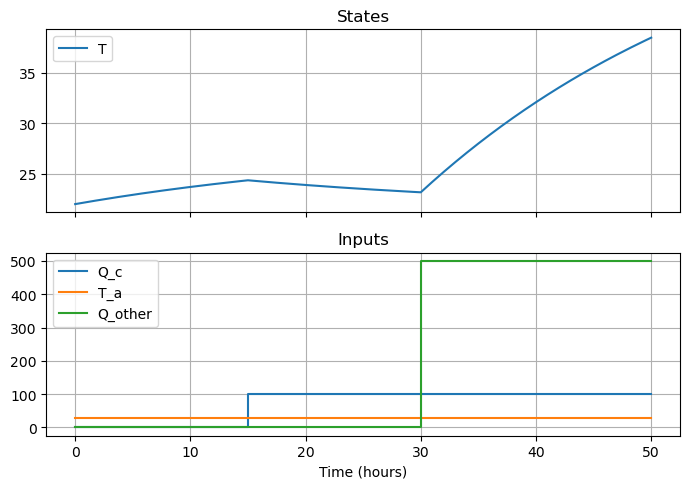

In [5]:
# Simulation inputs
nT = 200
t = dt * np.arange(nT+1)
U = np.zeros((nT+1, nu))
U[t >= 15, 0] = 100.0   # Q_c
U[:, 1] = 28.0  # T_a
U[t >= 30, 2] = 500.0   # Q_other

# Initial condition
x0 = 22.0  # zone temperature

def simulate_system(F, U, nx, x0):
    nT = U.shape[0] - 1
    X = np.full((nT+1, nx), np.nan)
    xk = x0
    for k in range(nT+1):
        X[k, :] = np.array(xk).reshape(-1)
        uk = U[k, :].T
        xk = F(xk, uk)
    return X

# Simulation loop
X = simulate_system(F, U, nx, x0)

# Plot results
def make_inputs_states_plot(t, X, U, figsize=(7, 5), x_labels=None, 
                            u_labels=None, time_label="Time (hours)"):
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=figsize)
    ax = axes[0]
    ax.plot(t, X)
    ax.grid()
    ax.legend(x_labels)
    ax.set_title('States')
    ax = axes[1]
    ax.step(t, U, where='post')
    ax.set_xlabel(time_label)
    ax.grid()
    ax.legend(u_labels)
    ax.set_title('Inputs')
    return fig, axes

make_inputs_states_plot(t, X, U, x_labels=['T'], u_labels=['Q_c', 'T_a', 'Q_other'])
plt.tight_layout()
plt.show()

## Simulate single zone with cooling, disturbance inputs and proportional controller

One state variable:

$$x(t) = T(t)$$

Three inputs:

$$\mathbf{u}(t) = \begin{bmatrix} T_{sp} \\ T_a \\ \dot{Q}_\text{other} \end{bmatrix}$$

In [6]:
# Constants
C = 450.0  # thermal capacitance, kJ/K
H = 15.0   # scaled heat transfer coefficient with ambient, kW/K
K_c = -560  # controller gain parameter
Q_ss = 0    # steady-state rate of cooling

# System dimensions
nx = 1
nu = 3

# States
x = cas.MX.sym('x', nx)
u = cas.MX.sym('x', nu)

T = x  # zone temperature
T_sp = u[0]  # zone temperature setpoint
T_a = u[1]  # ambient temperature
Q_other = u[2]  # external heat load, e.g. insolation or disturbance

# Define ODE
eps = T_sp - T  # tracking error
Q_c = Q_ss + K_c * eps  # control action
dTdt = (-H * (T - T_a) - Q_c + Q_other) / C  # rate-of-change of zone temperature

rhs = dTdt
f = cas.Function('f', [x, u], [rhs], ['x', 'u'], ['dxdt'])
print(f)

f:(x,u[3])->(dxdt) MXFunction


In [7]:
# Construct integrator
dt = 0.25  # timestep size, hours
intg = make_integrator(f, x, u, dt)
print(intg)

intg:(x0,z0[0],p[3],u[0],adj_xf[],adj_zf[],adj_qf[])->(xf,zf[0],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) RungeKutta


In [8]:
# Construct discretized system model
res = intg(x0=x, p=u)
xf = res['xf']
# Discretized system dynamics
F = cas.Function('F', [x, u], [xf], ['xk', 'uk'], ['xkp1'])
print(F)

F:(xk,uk[3])->(xkp1) MXFunction


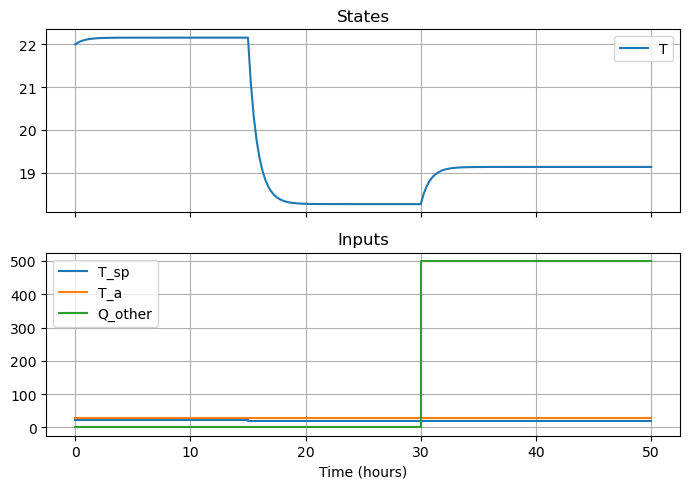

In [9]:
# Simulation inputs
nT = 200
t = dt * np.arange(nT+1)
X = np.full((nT+1, nx), np.nan)
U = np.zeros((nT+1, nu))
U[:, 0] = 22.0   # T_sp
U[t >= 15, 0] = 18.0   # T_sp
U[:, 1] = 28.0  # T_a
U[t >= 30, 2] = 500.0   # Q_other

# Initial condition
x0 = 22.0  # zone temperature

# Simulation loop
X = simulate_system(F, U, nx, x0)

# Plot results
make_inputs_states_plot(t, X, U, x_labels=['T'], u_labels=['T_sp', 'T_a', 'Q_other'])
plt.tight_layout()
plt.show()

In [10]:
rmse_tracking = np.sqrt(np.mean((X[:, 0] - U[:, 0]) ** 2))
print(f"Tracking error: {rmse_tracking:.2f}")

Tracking error: 0.84


## Simulate single zone with cooling, disturbance inputs and PI controller

State variables:

$$\mathbf{x}(t) = \begin{bmatrix} T(t) \\ \bar{\varepsilon}(t) \end{bmatrix}$$

Three inputs:

$$\mathbf{u}(t) = \begin{bmatrix} T_{sp} \\ T_a \\ \dot{Q}_\text{other} \end{bmatrix}$$

In [11]:
# Constants
C = 450.0  # thermal capacitance, kJ/K
H = 15.0   # scaled heat transfer coefficient with ambient, kW/K
K_c = -560  # controller gain parameter
tau_I = 1   # PI controller integral parameter
Q_ss = 0    # steady-state rate of cooling

# System dimensions
nx = 2
nu = 3

# States
x = cas.MX.sym('x', nx)
u = cas.MX.sym('x', nu)

T = x[0]  # zone temperature
I_eps = x[1]  # integral of tracking error
T_sp = u[0]  # zone temperature setpoint
T_a = u[1]  # ambient temperature
Q_other = u[2]  # external heat load, e.g. insolation or disturbance

# Define ODE
eps = T_sp - T  # tracking error
dI_eps_dt = eps
Q_c = Q_ss + K_c * (eps + I_eps / tau_I)  # control action
dTdt = (-H * (T - T_a) - Q_c + Q_other) / C  # rate-of-change of zone temperature

rhs = cas.vertcat(dTdt, dI_eps_dt)
f = cas.Function('f', [x, u], [rhs], ['x', 'u'], ['dxdt'])
print(f)

f:(x[2],u[3])->(dxdt[2]) MXFunction


In [12]:
# Construct integrator
dt = 0.25  # timestep size, hours
intg = make_integrator(f, x, u, dt)
print(intg)

intg:(x0[2],z0[0],p[3],u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[2],zf[0],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) RungeKutta


In [13]:
# Construct discretized system model
res = intg(x0=x, p=u)
xf = res['xf']
# Discretized system dynamics
F = cas.Function('F', [x, u], [xf], ['xk', 'uk'], ['xkp1'])
print(F)

F:(xk[2],uk[3])->(xkp1[2]) MXFunction


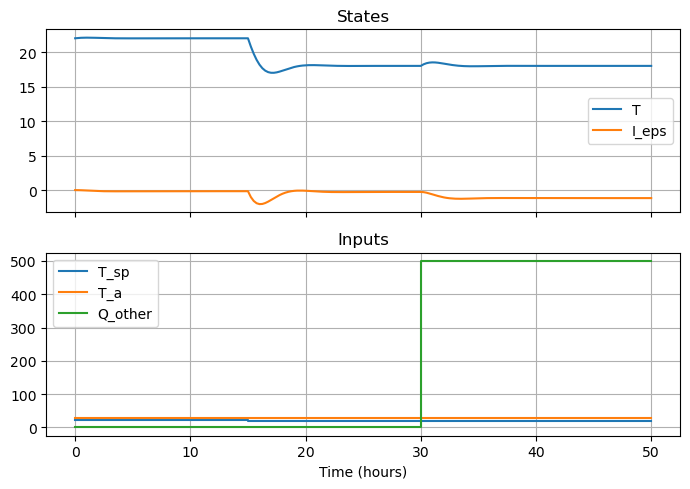

In [14]:
# Simulation inputs
nT = 200
t = dt * np.arange(nT+1)
X = np.full((nT+1, nx), np.nan)
U = np.zeros((nT+1, nu))
U[:, 0] = 22.0   # T_sp
U[t >= 15, 0] = 18.0   # T_sp
U[:, 1] = 28.0  # T_a
U[t >= 30, 2] = 500.0   # Q_other

# Initial condition
x0 = cas.vertcat(
    22.0,  # zone temperature
    0.0  # integral of traking error
)

# Simulation loop
X = simulate_system(F, U, nx, x0)

# Plot results
make_inputs_states_plot(t, X, U, x_labels=['T', 'I_eps'], u_labels=['T_sp', 'T_a', 'Q_other'])
plt.tight_layout()
plt.show()

In [15]:
rmse_tracking = np.sqrt(np.mean((X[:, 0] - U[:, 0]) ** 2))
print(f"Tracking error: {rmse_tracking:.2f}")

Tracking error: 0.42


## Data from Stanford Case Study

This data was made available from:
- https://hvacstudy.github.io/

In [16]:
data_dir = "data"
filename = "data.mat"

data = scipy.io.matlab.loadmat(os.path.join(data_dir, filename), simplify_cells=True)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'param', 'airside', 'waterside'])

In [17]:
{name: type(x) for name, x in data.items()}

{'__header__': bytes,
 '__version__': str,
 '__globals__': list,
 'param': dict,
 'airside': dict,
 'waterside': dict}

In [18]:
param = data['param']
param.keys()

dict_keys(['time', 'AmbientTemp', 'ElecPrices', 'DemandCharge', 'ComfortMin', 'ComfortMax', 'StorageCapacity'])

In [19]:
airside = data['airside']
airside.keys()

dict_keys(['H', 'C', 'Beta', 'Qss', 'Kc', 'tauI'])

In [20]:
waterside = data['waterside']
waterside.keys()

dict_keys(['common', 'chiller', 'pump', 'tower', 'tank'])

In [21]:
n_buildings = 25
assert data['airside']['C'].shape[0] == n_buildings

n_zones = 20
assert all([x.shape[0] for x in data['airside']['C']])


In [22]:
# Example of airside coefficients
building = 0
zone = 9
{p: airside[p][building][zone] for p in ['H', 'C', 'Qss', 'Kc', 'tauI']}

{'H': 15.14116470241531,
 'C': 438.2875387003527,
 'Qss': 0,
 'Kc': -560,
 'tauI': 1}

In [23]:
airside['Beta'][building][zone]

array([0.14570582, 0.13657539, 0.15410582, 0.15091977, 0.15063744,
       0.150666  , 0.14805606, 0.14147962, 0.14821616, 0.        ,
       0.14741695, 0.14932725, 0.14824992, 0.14464378, 0.14673437,
       0.14295033, 0.14881521, 0.14169108, 0.14196478, 0.14287258])